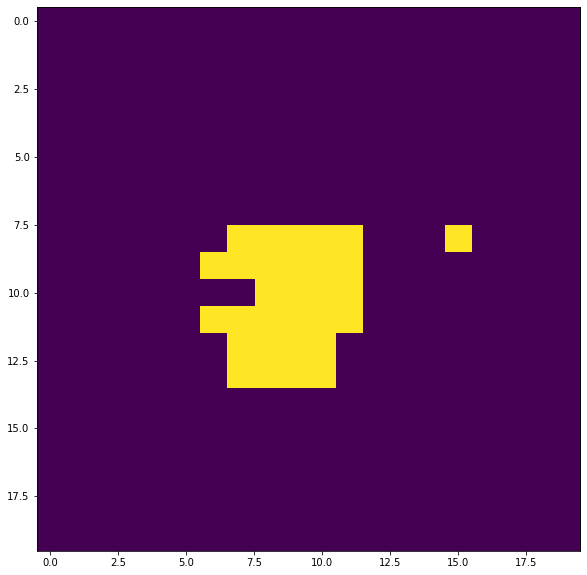

In [147]:
import matplotlib.pyplot as plt
import numpy as np

test_array = np.zeros([20,20])
test_array[8:14,6:12] = 1
test_array[8:9,6] = 0
test_array[12:14,11] = 0
test_array[12:14,6] = 0
test_array[10,:8] = 0

test_array[8,15] = 1


fig,ax=plt.subplots(figsize=(10,10))
ax.imshow(test_array)


In [256]:
from collections import defaultdict
import numpy as np

def zero_crossings(vector):
    """ Returns the positions of the zero crossings
    Args:
        vector: Vector with potentially positive and negative values
    Returns:
        zero_crossings: Position of the zero crossings
    """
    return np.where(np.diff(np.sign(vector)))[0]

def get_start_stop(vector):
    """ Checks for continuous segments of ones and returns start and stop coordinates
    Args:
        vector: Binary numpy array
    Returns:
        row_start_stop: 
    """
    row_start_stop = zero_crossings(vector-0.5)
    assert len(row_start_stop)%2 == 0
    row_start_stop = np.split(row_start_stop, len(row_start_stop)//2)
    row_start_stop = [list(item) for item in row_start_stop]
    return row_start_stop

def triangulate_pixels(array):
    """ Converts pixels into coordinates of triangles that cover the area of the pixels
    Args: 
        array: Binary array with foreground and background pixels
    Returns: 
        triangles: Numpy array of coordinates for triangles that cover the pixels.
                    Each triple of subsequent coordinates relates to a triangle.
             
    """
    rects = get_rectangles(array)
    top_left = rects[:,[0,2]]
    bottom_left = rects[:,[1,2]]
    bottom_right = rects[:,[1,3]]
    top_right = rects[:,[2,3]]
    
    triangles1 = np.ndarray((len(rects)*3,2))
    triangles1[::3,:] = top_left
    triangles1[1::3,:] = bottom_left
    triangles1[2::3,:] = bottom_right
    
    triangles2 = np.ndarray((len(rects)*3,2))
    triangles2[::3,:] = top_left
    triangles2[1::3,:] = top_right
    triangles2[2::3,:] = bottom_right
    
    triangles = np.vstack([triangles1,triangles2])

    return triangles


def get_rectangles(array):
    """ Splits foreground pixels of array into rectangles by scanning row wise for changes.
    Args:
        array: Binary array of pixels
    Returns:
        rectangle: Numpy array where each row contains the coordinates in order: left, right top and bottom 
    """
    ys, xs = np.where(array)
    ys = list(set(ys))
    old_start_stop = get_start_stop(array[ys[0],:])#e.g. [[ 6, 11], [14, 15]]
    left_right_to_top = defaultdict(dict)
    
    for left, right in old_start_stop:
        left_right_to_top[left][right] = ys[0]
        
    rectangles = []
    
    for y in ys[1:]:
        new_start_stop = get_start_stop(array[y,:])
        for old in old_start_stop:
            if not old in new_start_stop:
                bottom = y - 1
                left = old[0]
                right = old[1]
                top = left_right_to_top[left][right]
                rectangles.append([left+1,right,top,bottom])
                del(left_right_to_top[left][right])
        for new in new_start_stop:
            if not new in old_start_stop:
                left = new[0]
                right = new[1]
                left_right_to_top[left][right] = y
        old_start_stop = new_start_stop
    
    #The last ones
    for left, right in old_start_stop:
        bottom = ys[-1]
        top = left_right_to_top[left][right]
        rectangles.append([left+1,right,top,bottom])
        
        
    rectangle = np.array(rectangles, dtype=np.float64)
    rectangle[:,0] -= 0.5
    rectangle[:,1] += 0.5
    rectangle[:,2] -= 0.5
    rectangle[:,3] += 0.5
    return rectangle

In [254]:
rects = get_rectangles(test_array)
rects

array([[ 6.5, 11.5,  7.5,  8.5],
       [14.5, 15.5,  7.5,  8.5],
       [ 5.5, 11.5,  8.5,  9.5],
       [ 7.5, 11.5,  9.5, 10.5],
       [ 5.5, 11.5, 10.5, 11.5],
       [ 6.5, 10.5, 11.5, 13.5]])

In [255]:
tris = triangulate_pixels(test_array)
tris

array([[ 6.5,  7.5],
       [11.5,  7.5],
       [11.5,  8.5],
       [14.5,  7.5],
       [15.5,  7.5],
       [15.5,  8.5],
       [ 5.5,  8.5],
       [11.5,  8.5],
       [11.5,  9.5],
       [ 7.5,  9.5],
       [11.5,  9.5],
       [11.5, 10.5],
       [ 5.5, 10.5],
       [11.5, 10.5],
       [11.5, 11.5],
       [ 6.5, 11.5],
       [10.5, 11.5],
       [10.5, 13.5],
       [ 6.5,  7.5],
       [ 7.5,  8.5],
       [11.5,  8.5],
       [14.5,  7.5],
       [ 7.5,  8.5],
       [15.5,  8.5],
       [ 5.5,  8.5],
       [ 8.5,  9.5],
       [11.5,  9.5],
       [ 7.5,  9.5],
       [ 9.5, 10.5],
       [11.5, 10.5],
       [ 5.5, 10.5],
       [10.5, 11.5],
       [11.5, 11.5],
       [ 6.5, 11.5],
       [11.5, 13.5],
       [10.5, 13.5]])

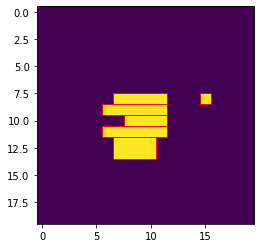

In [227]:
import matplotlib.patches as patches
fig, ax = plt.subplots()

for left, right, top, bottom in rects:
    rect = patches.Rectangle((left,bottom),right-left,top-bottom,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
ax.imshow(test_array)


In [228]:
[6,11] in get_start_stop(test_array[ys[0],:])

True

In [229]:
ys, xs = np.where(test_array)
ys = list(set(ys))
row_start_stop = zero_crossings(-.5)
assert len(row_start_stop)%2 == 0
row_start_stop = np.split(row_start_stop, 2)

ValueError: diff requires input that is at least one dimensional

In [182]:
row_start_stop

[array([ 6, 11]), array([14, 15])]

In [47]:
rectangles = []
current_left_vals = []
current_right_vals = []

for y in set(ys):
    row_start_stop = zero_crossings(test_array[y,:]-.5)
    assert len(row_start_stop)%2 == 0
    row_start_stop = np.split(row_start_stop, 2)
    print(row_start_stop)
    


[array([ 6, 11]), array([14, 15])]
[array([5]), array([11])]
[array([7]), array([11])]
[array([5]), array([11])]
[array([5]), array([11])]
[array([6]), array([10])]
